# 1. Import Libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
from googletrans import Translator

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [81]:
# restrict tf from using all available memory on gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [82]:
# set random seed for reproducibility
np.random.seed(1)

# 2. Load Datasets

In [83]:
# change current working directory
path = r'D:\SP\Year 2 Sem 1\ST1504 Deep Learning\CA1\Part B'
os.chdir(path)

In [84]:
# load dataset
df = pd.read_csv('Movie reviews.csv')
df

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,NaN,Malay
...,...,...,...,...
522,Pening,0.7,NaN,Malay
523,Berkesan,0.2,NaN,Malay
524,Mengujakan,0.1,NaN,Malay
525,Sederhana and teruk,0.6,NaN,Malay


In [85]:
# remove 3rd column
df = df.drop(df.columns[2], axis=1)

# 3. Exploratory Data Analysis & Data Preprocessing

Before we start building the model, we can either do classification or regression. I have chosen classification (either positively sentimented or negatively sentimented) rather than regression (predicting the score) as the model will only have to predict two classes rather than a continuous value which may improve the model's performance

## A. Language

### i. Visualisation

In [86]:
# view all the different languages in the dataset
df.Language.unique()

array(['Malay', 'English', 'Chinese', 'Nippon'], dtype=object)

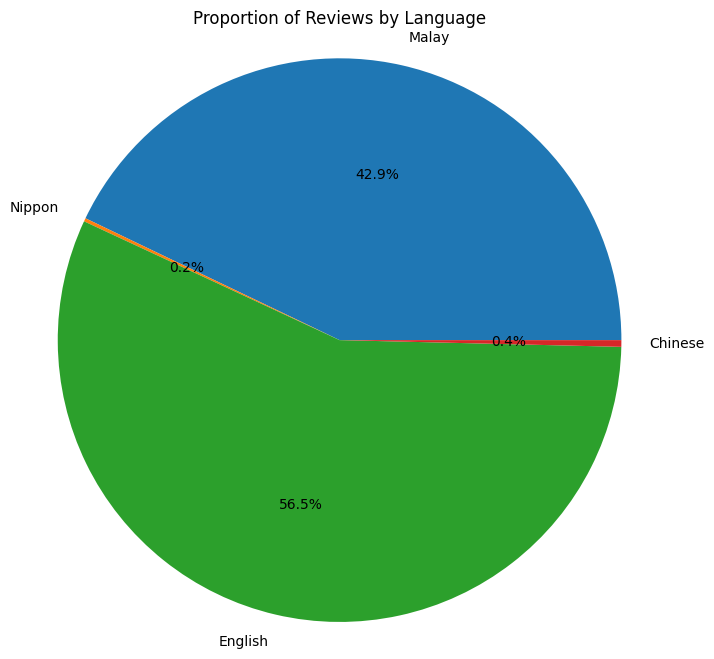

In [87]:
review_counts_by_language = {
    'Malay': len(df[df.Language == 'Malay']),
    'Nippon': len(df[df.Language == 'Nippon']),
    'English': len(df[df.Language == 'English']),
    'Chinese': len(df[df.Language == 'Chinese'])
}

languages = list(review_counts_by_language.keys())
counts = list(review_counts_by_language.values())

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=languages, autopct='%1.1f%%')  # round to 1 decimal place with percentage sign
plt.title('Proportion of Reviews by Language')
plt.axis('equal')  # equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [88]:
print(f'Number of reviews in Nippon: {review_counts_by_language["Nippon"]}')
print(f'Number of reviews in Chinese: {review_counts_by_language["Chinese"]}')

Number of reviews in Nippon: 1
Number of reviews in Chinese: 2


From the pie chart, we can see that the dataset is imbalanced in the type of languages used. The majority of the dataset is in English, followed by Malay. The other languages (Chinese and Japanese) are not as common in the dataset. Hence we can remove the Chinese and Japanese reviews from the dataset.

### ii. Drop Chinese and Japanese reviews

In [89]:
df = df.drop(df[(df.Language == 'Nippon') | (df.Language == 'Chinese')].index)
df.Language.unique()

array(['Malay', 'English'], dtype=object)

At this point, we have 2 options:

1. Translate the Malay reviews to English

2. Split the dataset into their respective languages and train 2 separate models for each language

As having two separate models for each language would be more computationally expensive, we will opt for the first option and translate the Malay reviews to English. Furthermore, if we separate the dataset into their respective languages, we would have a smaller dataset to train on which may not be sufficient to train a model with a good performance

### iii. Translate Malay reviews to English

In [90]:
def translate_malay_to_english(text):
    translator = Translator()
    results = translator.translate(text, src='ms', dest='en')  # translate from malay to english

    return results.text

In [91]:
malay_reviews = df[df.Language == 'Malay']['Review']

df.loc[df['Language'] == 'Malay', 'Review'] = malay_reviews.apply(translate_malay_to_english)
df = df.drop(columns=['Language'])
df

,Review,Score
0,This movie is great! Thrilling action and a su...,0.1
1,This movie is great! Thrilling action and a su...,0.9
2,This movie is great! Thrilling action and a su...,0.5
3,Too bad the actors didn't give their best perf...,0.8
4,A complex and emotional storyline. Really ente...,0.2
...,...,...
522,Dizziness,0.7
523,Effective,0.2
524,Exciting,0.1
525,Simple and bad,0.6


## B. Score

### i. Score Definition

In [92]:
df.head(10)

,Review,Score
0,This movie is great! Thrilling action and a su...,0.10
1,This movie is great! Thrilling action and a su...,0.90
2,This movie is great! Thrilling action and a su...,0.50
3,Too bad the actors didn't give their best perf...,0.80
4,A complex and emotional storyline. Really ente...,0.20
5,The filmmakers managed to provide an unforgett...,0.05
6,Too many action scenes and shocks. Sometimes a...,0.40
7,I was excited throughout the movie. Interestin...,0.15
8,Avengers: Endgame is disappointing and boring....,0.85
9,The integration of science fiction elements is...,0.25


If we look at row 7, the review is positive. The score is 0.15 (low)

If we look at row 3, the review is negative. The score is 0.80 (high)

We can assume that the lower the score, the more positive the review is

### ii. Check for missing values

In [93]:
df[df['Score'].isnull() == True]

,Review,Score
493,Diabolic,NaN


Since there is only 1 review where the score is missing, we can just remove this review from the dataset

In [94]:
df = df.drop(493)
df[df['Score'].isnull() == True]

,Review,Score


### iii. Visualize the distribution of the scores

In [95]:
min_score = min(df['Score'])
max_score = max(df['Score'])
print(f'Min Score: {min_score}')
print(f'Max Score: {max_score}')

Min Score: 0.05
Max Score: 0.99


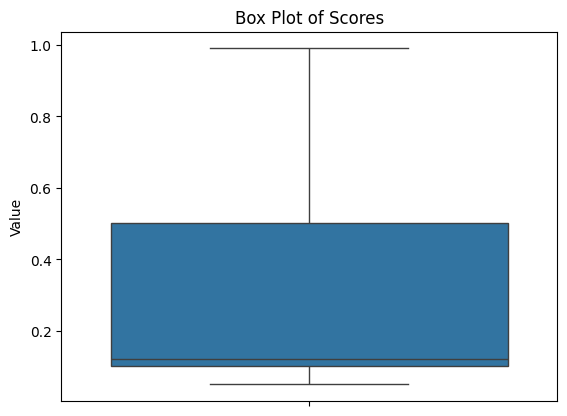

In [96]:
sns.boxplot(y=df['Score'])
plt.title('Box Plot of Scores')
plt.ylabel('Value')
plt.show()

From the boxplot, we can see that the dataset has more positive reviews than negative reviews with a median score of about 0.1. This suggests that the dataset is biased towards positive reviews

## C. Reviews

### i. Check for duplicates

These are rows whereby the review and score and language are all the same. Hence, we can just remove them from the dataset

In [97]:
df[df.duplicated()]

,Review,Score
68,The lack of character development makes this f...,0.75
69,I'm excited about how this movie incorporates ...,0.20
70,Interesting plot and full of surprises. I like...,0.15
71,This film has great emotional power. Touching!,0.12
72,The actor gave an unsatisfactory performance. ...,0.75
...,...,...
418,Spectacular,0.08
433,Impressive,0.08
447,Moving,0.12
509,Disappointing,0.80


In [98]:
df = df.drop_duplicates()
df[df.duplicated()]

,Review,Score


In [99]:
df = df.reset_index(drop=True)
df

,Review,Score
0,This movie is great! Thrilling action and a su...,0.1
1,This movie is great! Thrilling action and a su...,0.9
2,This movie is great! Thrilling action and a su...,0.5
3,Too bad the actors didn't give their best perf...,0.8
4,A complex and emotional storyline. Really ente...,0.2
...,...,...
399,Captivating,0.2
400,Dizziness,0.7
401,Effective,0.2
402,Simple and bad,0.6


### ii. Check for review text duplicates

These are rows whereby the review text is the same but the score is not the same. Hence, we will manually go through each review text and translate if necessary to determine which score it should have

In [100]:
# find all reviews that are duplicated (i.e. have the same text)
duplicated_reviews_df = df[df.duplicated(subset='Review', keep=False)].sort_values('Review')
print(f'Number of duplicated reviews: {len(duplicated_reviews_df)}')
duplicated_reviews_df

Number of duplicated reviews: 31


,Review,Score
322,Amazing,0.12
397,Amazing,0.10
399,Captivating,0.20
311,Captivating,0.12
324,Complex,0.10
302,Complex,0.65
386,Epic,0.70
289,Epic,0.06
387,Great,0.10
308,Great,0.08


I manually went through the reviews and determined their sentiment. From there, if the reviews' score matched the sentiment, I will calculate the average scores and update it to the first review, while dropping the other reviews. If the reviews' score did not match the sentiment, I will select based on the score closest to the sentiment and dropping the other reviews

### iii. Remove review text duplicates

In [34]:
rows_to_drop = [324, 386, 2, 1, 329]

In [35]:
def average_score(*rows):
    """
    Calculates average score of specified rows. Updates the mean score into the first row. Appends remaining rows to drop into rows_to_drop list.
    """
    scores = []

    for row in list(rows):
        scores.append(df.iloc[row, :]['Score'])

    mean_score = np.mean(np.array(scores))
    
    df.iloc[rows[0], 1] = mean_score
    
    for i in rows[1:]:
        rows_to_drop.append(i)

In [36]:
average_score(322, 397)
average_score(399, 311)
average_score(387, 308)
average_score(87, 23)
average_score(298, 391)
average_score(293, 328)
average_score(145, 165)
average_score(91, 26)
average_score(89, 25)
average_score(137, 166)
average_score(88, 24)

In [37]:
df = df.drop(rows_to_drop)
df[df.duplicated(subset='Review', keep=False)]

,Review,Score


## D. Sentiment

### i. Split reviews according to sentiment

In [38]:
df['Negative'] = df['Score'].apply(lambda x: 1 if x > 0.5 else 0)
df = df.reset_index(drop=True)
df

,Review,Score,Negative
0,This movie is great! Thrilling action and a su...,0.10,0
1,Too bad the actors didn't give their best perf...,0.80,1
2,A complex and emotional storyline. Really ente...,0.20,0
3,The filmmakers managed to provide an unforgett...,0.05,0
4,Too many action scenes and shocks. Sometimes a...,0.40,0
...,...,...,...
383,Captivating,0.16,0
384,Dizziness,0.70,1
385,Effective,0.20,0
386,Simple and bad,0.60,1


In [39]:
df = df.drop(columns=['Score'])
df

,Review,Negative
0,This movie is great! Thrilling action and a su...,0
1,Too bad the actors didn't give their best perf...,1
2,A complex and emotional storyline. Really ente...,0
3,The filmmakers managed to provide an unforgett...,0
4,Too many action scenes and shocks. Sometimes a...,0
...,...,...
383,Captivating,0
384,Dizziness,1
385,Effective,0
386,Simple and bad,1


### ii. View sentiment distribution

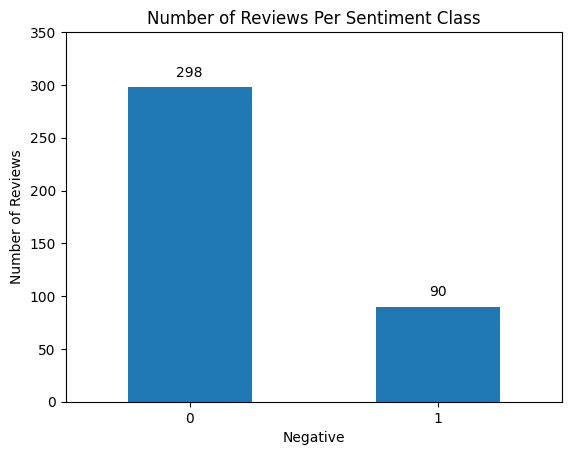

In [40]:
df['Negative'].value_counts().plot(kind='bar')

for index, count in enumerate(df['Negative'].value_counts()):
    plt.text(index, count+10, str(count), ha='center')

plt.title('Number of Reviews Per Sentiment Class')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.ylim(0, 350)
plt.show()

We can tell that there is a huge class imbalance in the dataset as we have seen earlier. Not only that, the number of reviews for each class are also fairly little which may not be enough to train a model with good performance. Hence, we will split the existing reviews into more reviews to generate more data by '.' or '!'

### iii. Generate more reviews

In [41]:
before_generation = len(df)
print(f'Number of reviews before generation: {before_generation}')

Number of reviews before generation: 388


In [42]:
df.loc[:, 'Review'] = df['Review'].apply(lambda x: x.split('.'))
df = df.explode('Review')

df.loc[:, 'Review'] = df['Review'].apply(lambda x: x.split('!'))
df = df.explode('Review')

df

,Review,Negative
0,This movie is great,0
0,Thrilling action and a surprising plot,0
0,,0
1,Too bad the actors didn't give their best perf...,1
1,Not satisfied,1
...,...,...
383,Captivating,0
384,Dizziness,1
385,Effective,0
386,Simple and bad,1


After generating more data, there might be some duplicates generated too. Hence, we will remove these duplicates

In [43]:
df[df.duplicated()]

,Review,Negative
2,,0
3,,0
4,,0
5,,0
6,,1
...,...,...
273,,0
274,,0
275,,0
276,,0


In [44]:
df = df.drop_duplicates()
df

,Review,Negative
0,This movie is great,0
0,Thrilling action and a surprising plot,0
0,,0
1,Too bad the actors didn't give their best perf...,1
1,Not satisfied,1
...,...,...
383,Captivating,0
384,Dizziness,1
385,Effective,0
386,Simple and bad,1


In [45]:
df = df[df['Review'] != '']
df

,Review,Negative
0,This movie is great,0
0,Thrilling action and a surprising plot,0
1,Too bad the actors didn't give their best perf...,1
1,Not satisfied,1
2,A complex and emotional storyline,0
...,...,...
383,Captivating,0
384,Dizziness,1
385,Effective,0
386,Simple and bad,1


In [46]:
print(f'Number of reviews after generation: {len(df)}')
print(f'Total number of reviews generated: {len(df) - before_generation}')

Number of reviews after generation: 640
Total number of reviews generated: 252


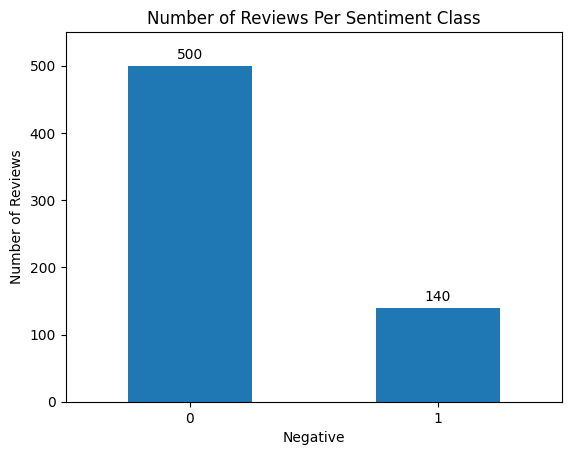

In [47]:
df['Negative'].value_counts().plot(kind='bar')
for index, count in enumerate(df['Negative'].value_counts()):
    plt.text(index, count+10, str(count), ha='center')
plt.title('Number of Reviews Per Sentiment Class')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.ylim(0, 550)
plt.show()

### iv. View review text length distribution

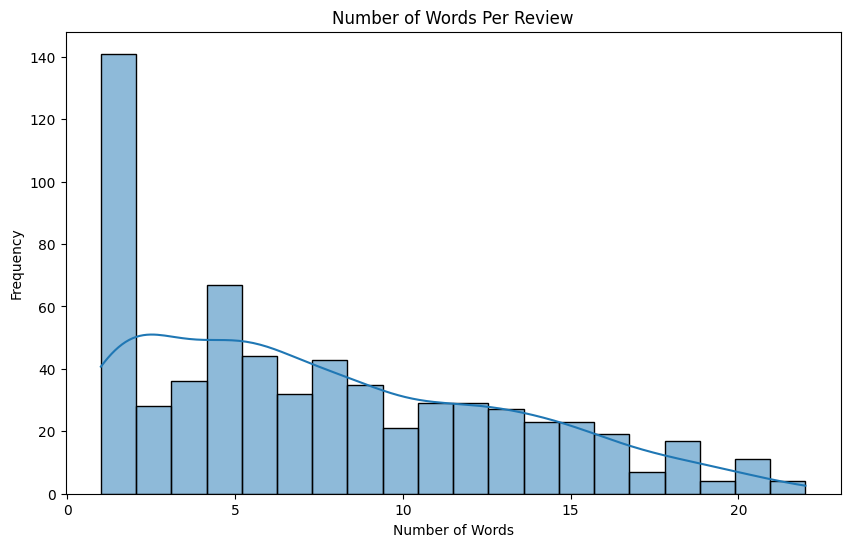

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Review'].apply(lambda x: len(x.split())), kde=True, bins=20)
plt.title('Number of Words Per Review')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

From the graph, we can see that there are many 1 worded reviews. The model may perform better with 1 worded reviews than others

## E. Tokenization

In [49]:
reviews = df['Review']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
print(tokenizer.word_index)

{'the': 1, 'a': 2, 'of': 3, 'and': 4, 'to': 5, 'is': 6, 'film': 7, 'this': 8, 'action': 9, 'plot': 10, 'avengers': 11, 'in': 12, 'endgame': 13, 'i': 14, 'with': 15, 'are': 16, 'visual': 17, 'effects': 18, 'movie': 19, 'emotional': 20, 'that': 21, 'narrative': 22, 'an': 23, 'cinematic': 24, 'character': 25, 'experience': 26, 'conclusion': 27, 'it': 28, "film's": 29, 'too': 30, 'scenes': 31, 'sequences': 32, 'epic': 33, 'while': 34, 'moments': 35, 'amazing': 36, 'its': 37, 'performances': 38, 'not': 39, 'characters': 40, 'marvel': 41, 'creating': 42, 'interesting': 43, 'storytelling': 44, 'elements': 45, 'like': 46, "i'm": 47, 'from': 48, 'for': 49, 'thrilling': 50, 'story': 51, 'twist': 52, 'may': 53, 'actors': 54, 'end': 55, 'depth': 56, 'some': 57, 'complex': 58, 'very': 59, 'overall': 60, 'but': 61, 'cast': 62, 'by': 63, 'satisfying': 64, 'spectacle': 65, 'audience': 66, 'visually': 67, 'great': 68, 'excited': 69, 'how': 70, 'outstanding': 71, 'twists': 72, 'visuals': 73, 'stunning':

In [50]:
vocab_size = len(tokenizer.word_index) + 1  # index 0 is reserved for padding
print(f'Vocab size: {vocab_size}')

Vocab size: 815


In [51]:
tokenised_reviews = tokenizer.texts_to_sequences(reviews)
print(tokenised_reviews)

[[8, 19, 6, 68], [50, 9, 4, 2, 118, 10], [30, 263, 1, 54, 264, 173, 77, 496, 38], [39, 265], [2, 58, 4, 20, 78], [147, 128], [1, 497, 498, 5, 266, 23, 267, 26], [356, 36], [30, 92, 9, 31, 4, 499], [212, 2, 174, 30, 268], [14, 105, 69, 129, 1, 19], [43, 44], [11, 13, 6, 106, 4, 500], [30, 92, 501], [1, 357, 3, 119, 120, 45, 6, 59, 43], [14, 46], [8, 7, 6, 358, 15, 93, 20, 359], [60, 23, 213, 24, 26], [14, 269, 502], [14, 360, 8, 19, 6, 39, 94, 270, 94, 28, 503], [214, 504], [36, 9, 4, 2, 10, 175, 3, 271], [1, 17, 176, 3, 8, 19, 6, 36], [47, 69], [14, 148, 46, 1, 361, 1, 272, 215, 79, 1, 149], [150, 273], [216, 61, 59, 43, 78], [9, 31, 21, 16, 30, 217, 4, 274], [39, 505], [8, 19, 147, 506, 95, 507], [14, 105, 121, 15, 1, 508, 362], [1, 62, 151, 2, 68, 107], [14, 85, 8, 51], [14, 148, 275, 1, 10, 3, 8, 19], [30, 58], [130, 131, 12, 1, 10], [152, 9, 129, 1, 7], [17, 18, 16, 68, 61, 1, 10, 6, 150, 43], [14, 80, 218], [36, 9, 31], [14, 80, 69, 363, 1, 122], [30, 263, 1, 10, 3, 8, 19, 6, 30, 

## F. Padding

In [52]:
longest_review = max(tokenised_reviews, key=len)
longest_length = len(longest_review)
print(f'Longest review: {longest_review}')
print(f'Length: {longest_length}')

Longest review: [1, 29, 171, 5, 258, 2, 656, 4, 408, 226, 6, 2, 115, 5, 1, 657, 4, 658, 3, 1, 144, 329]
Length: 22


In [53]:
tokenised_reviews = pad_sequences(tokenised_reviews, maxlen=longest_length, padding='post')  # add 0s behind
tokenised_reviews.shape

(640, 22)

## G. Train Test Validation Split

In [54]:
sentiment = df['Negative'].values
sentiment.shape

(640,)

We will do a 70-15-15 split for the train, test and validation datasets respectively as we do not have a lot of data. We will also use stratified sampling to ensure that the distribution of the classes are the same across all datasets as the dataset is imbalanced

In [55]:
X_train, X_test, y_train, y_test = train_test_split(tokenised_reviews, sentiment, stratify=sentiment, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=42)

In [56]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of y_val: {y_val.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (448, 22)
Shape of y_train: (448,)
Shape of X_val: (96, 22)
Shape of y_val: (96,)
Shape of X_test: (96, 22)
Shape of y_test: (96,)


## H. Class Weights

In [57]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.64, 1: 2.2857142857142856}

# 4. Model Training

Define plot functions

In [58]:
def plot_acc(hist):
    """
    Plot a line graph comparing the training and validation accuracy
    """
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

In [59]:
def plot_loss(hist):
    """
    Plot a line graph comparing the training and validation loss
    """
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## A. Base Model

As this will be our first model, I will not make the model too complicated with too many layers

In [48]:
model1 = Sequential([
    Embedding(vocab_size, 100, input_length=tokenised_reviews.shape[1]),

    Conv1D(64, kernel_size=5, activation='relu'),

    LSTM(64, return_sequences=True),

    LSTM(64),

    Dense(32, activation='relu'),

    Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           81300     
                                                                 
 conv1d (Conv1D)             (None, 18, 64)            32064     
                                                                 
 lstm (LSTM)                 (None, 18, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 181,525
Trainable params: 181,525
Non-trai

In [49]:
history1 = model1.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val), 
    verbose=1,
    class_weight=class_weights_dict
)

Epoch 1/30
28/28 [==============================] - 3s 29ms/step - loss: 0.6913 - accuracy: 0.6742 - val_loss: 0.6939 - val_accuracy: 0.4526
Epoch 2/30
28/28 [==============================] - 0s 9ms/step - loss: 0.6026 - accuracy: 0.6112 - val_loss: 0.6675 - val_accuracy: 0.5368
Epoch 3/30
28/28 [==============================] - 0s 8ms/step - loss: 0.4077 - accuracy: 0.7865 - val_loss: 0.8552 - val_accuracy: 0.6842
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.3466 - accuracy: 0.8225 - val_loss: 0.4597 - val_accuracy: 0.7684
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.1575 - accuracy: 0.9461 - val_loss: 0.5477 - val_accuracy: 0.8105
Epoch 6/30
28/28 [==============================] - 0s 9ms/step - loss: 0.0739 - accuracy: 0.9775 - val_loss: 0.3644 - val_accuracy: 0.9053
Epoch 7/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0669 - accuracy: 0.9865 - val_loss: 0.5718 - val_accuracy: 0.8421
Epoch 8/30
28/28 [=

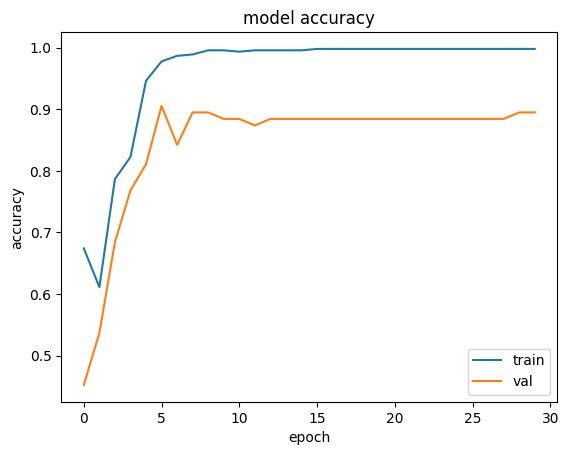

In [50]:
plot_acc(history1)

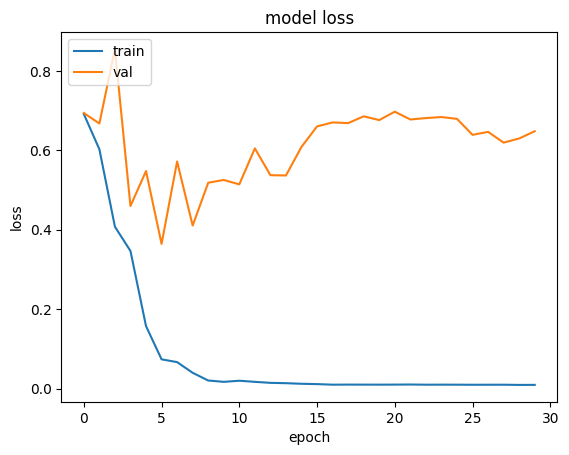

In [51]:
plot_loss(history1)

Although val accuracy is high and stays constant at around 0.9, the val loss is high and is increasing. We will try to add more layers and lower optimizer learning rate to see if it improves the model's performance

## B. Add More Layers and Change Optimizer Learning Rate

In [66]:
model2 = Sequential([
    Embedding(vocab_size, 100, input_length=tokenised_reviews.shape[1]),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(64)),
    Dropout(0.4),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           81500     
                                                                 
 bidirectional (Bidirectiona  (None, 22, 128)          84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

In [67]:
history2 = model2.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/60
28/28 [==============================] - 4s 43ms/step - loss: 1.1592 - accuracy: 0.7433 - val_loss: 1.1258 - val_accuracy: 0.7812
Epoch 2/60
28/28 [==============================] - 0s 9ms/step - loss: 1.0996 - accuracy: 0.7812 - val_loss: 1.0519 - val_accuracy: 0.7812
Epoch 3/60
28/28 [==============================] - 0s 9ms/step - loss: 1.0328 - accuracy: 0.7812 - val_loss: 0.9910 - val_accuracy: 0.7812
Epoch 4/60
28/28 [==============================] - 0s 9ms/step - loss: 0.9845 - accuracy: 0.7812 - val_loss: 0.9695 - val_accuracy: 0.7812
Epoch 5/60
28/28 [==============================] - 0s 9ms/step - loss: 0.9744 - accuracy: 0.7812 - val_loss: 0.9501 - val_accuracy: 0.7812
Epoch 6/60
28/28 [==============================] - 0s 9ms/step - loss: 0.9341 - accuracy: 0.7812 - val_loss: 0.9300 - val_accuracy: 0.7812
Epoch 7/60
28/28 [==============================] - 0s 11ms/step - loss: 0.9212 - accuracy: 0.7812 - val_loss: 0.9100 - val_accuracy: 0.7812
Epoch 8/60
28/28 [

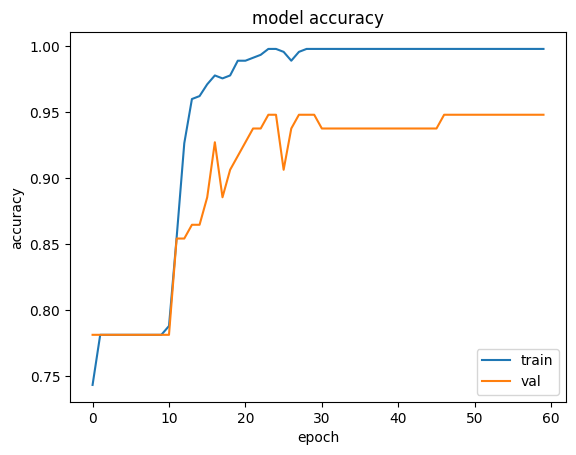

In [68]:
plot_acc(history2)

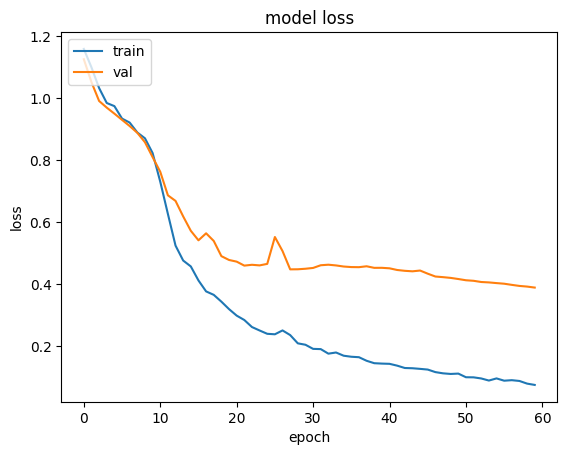

In [69]:
plot_loss(history2)

Although the val accuracy fluctuates, it starts to smoothen out at the later epochs. The val loss also decreases as the epochs increase. As the model's performance is good, we shall choose this model as our final model

In [70]:
model2.save('model2.h5')
model2.save_weights('model2_weights.h5')

# 5. Model Evaluation

In [71]:
loaded_model = load_model('model2.h5')

In [72]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           81500     
                                                                 
 bidirectional (Bidirectiona  (None, 22, 128)          84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

In [73]:
y_pred = loaded_model.predict(X_test)
print(y_pred)

3/3 [==============================] - 1s 5ms/step
[[2.9203102e-03]
 [4.2089267e-04]
 [4.0640065e-04]
 [4.4557315e-04]
 [3.9945467e-04]
 [9.8771614e-01]
 [4.1795059e-04]
 [4.0693529e-04]
 [4.5562309e-04]
 [9.8877436e-01]
 [9.8880976e-01]
 [4.0622117e-04]
 [4.6009582e-04]
 [3.9685471e-04]
 [4.0853085e-04]
 [4.0676480e-04]
 [5.9639959e-04]
 [3.9545359e-04]
 [9.8894870e-01]
 [4.3445965e-04]
 [4.1883442e-04]
 [3.9655459e-04]
 [3.9688079e-04]
 [4.1716959e-04]
 [4.1851334e-04]
 [3.9659470e-04]
 [4.6292981e-04]
 [4.8679870e-04]
 [9.6076232e-01]
 [4.4980957e-04]
 [4.1464643e-04]
 [9.8501801e-01]
 [3.2477800e-03]
 [3.9267784e-04]
 [4.3163131e-04]
 [5.8577798e-04]
 [5.3593074e-04]
 [4.3284183e-04]
 [4.0409938e-04]
 [9.8549455e-01]
 [5.0405622e-04]
 [5.9984851e-04]
 [9.8374796e-01]
 [9.8818284e-01]
 [2.5717192e-03]
 [3.9487082e-04]
 [4.0913318e-04]
 [4.1718295e-04]
 [4.8656418e-04]
 [4.0590143e-04]
 [9.8843759e-01]
 [4.2087882e-04]
 [4.1842833e-04]
 [9.8091434e-04]
 [6.3679693e-04]
 [4.9237406e-0

In [74]:
loss, accuracy = loaded_model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 5ms/step - loss: 0.7072 - accuracy: 0.8854


In [75]:
y_pred_binary = (y_pred > 0.5).astype(int)
print(y_pred_binary)

[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]]


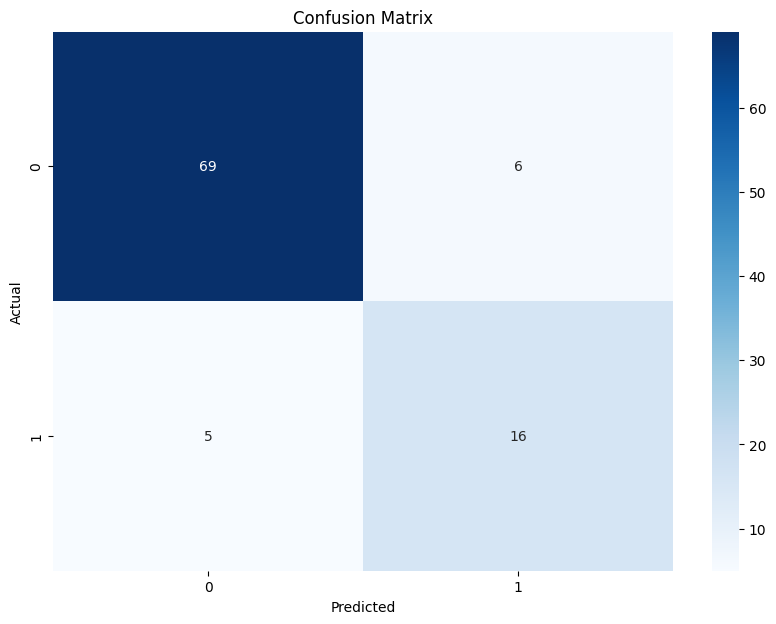

In [76]:
cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])  # fmt='d' formats to integers
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix')
plt.show()

In [79]:
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.93      0.92      0.93        75
    Positive       0.73      0.76      0.74        21

    accuracy                           0.89        96
   macro avg       0.83      0.84      0.84        96
weighted avg       0.89      0.89      0.89        96



The model performs well overall, especially on the Negative class. That is due to having an imbalance in the classes (having more negatives). However, there is room for improvement in predicting the Positive class such as resampling. This could be due to class imbalance or the model not learning the Positive class features as effectively even with class weights.

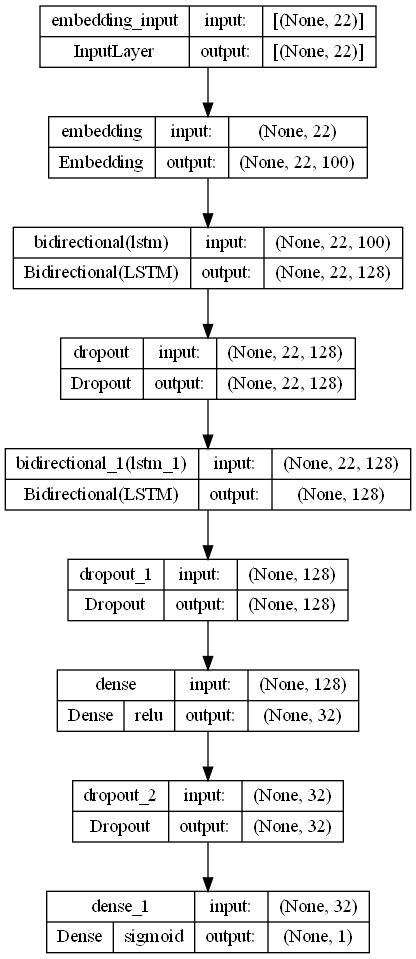

In [78]:
plot_model(loaded_model, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=True, to_file="model2.png")